In [40]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, ConcatDataset
import time
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, recall_score
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from imblearn.under_sampling import RandomUnderSampler
import itertools
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.ticker as ticker
import os

In [2]:
from dataloader_creator import CreatorDL
creator = CreatorDL(seed=42, bs=32)

In [3]:
df_UNSW = creator.reader("NF-UNSW-NB15-v3")

df_train_UNSW, df_test_UNSW, df_val_UNSW = creator.splitter(df_UNSW)

train_loader_UNSW, test_loader_UNSW, val_loader_UNSW = creator.balancer(df_train_UNSW, df_test_UNSW, df_val_UNSW)

Processando a categoria: 'Benign'
  -> Treino: 1118865 | Teste: 559433 | Validação: 559433
Processando a categoria: 'Fuzzers'
  -> Treino: 16908 | Teste: 8454 | Validação: 8454
Processando a categoria: 'Exploits'
  -> Treino: 21374 | Teste: 10687 | Validação: 10687
Processando a categoria: 'Backdoor'
  -> Treino: 2329 | Teste: 1165 | Validação: 1165
Processando a categoria: 'Reconnaissance'
  -> Treino: 8537 | Teste: 4268 | Validação: 4269
Processando a categoria: 'Generic'
  -> Treino: 9825 | Teste: 4913 | Validação: 4913
Processando a categoria: 'DoS'
  -> Treino: 2990 | Teste: 1495 | Validação: 1495
Processando a categoria: 'Shellcode'
  -> Treino: 1190 | Teste: 595 | Validação: 596
Processando a categoria: 'Analysis'
  -> Treino: 613 | Teste: 306 | Validação: 307
Processando a categoria: 'Worms'
  -> Treino: 79 | Teste: 39 | Validação: 40

--- Base de Treino ---
Tamanho: 1182710 linhas
Categorias presentes: ['Benign' 'Exploits' 'Reconnaissance' 'Fuzzers' 'DoS' 'Generic' 'Backdoor'


In [4]:
df_BOT= creator.reader("NF-BoT-IoT-v3")

df_train_BOT, df_test_BOT, df_val_BOT = creator.splitter(df_BOT)

train_loader_BOT, test_loader_BOT, val_loader_BOT = creator.balancer(df_train_BOT, df_test_BOT, df_val_BOT)

Processando a categoria: 'Benign'
  -> Treino: 25994 | Teste: 12997 | Validação: 12998
Processando a categoria: 'DDoS'
  -> Treino: 3575441 | Teste: 1787720 | Validação: 1787721
Processando a categoria: 'DoS'
  -> Treino: 4017095 | Teste: 2008547 | Validação: 2008548
Processando a categoria: 'Reconnaissance'
  -> Treino: 847566 | Teste: 423783 | Validação: 423783
Processando a categoria: 'Theft'
  -> Treino: 807 | Teste: 404 | Validação: 404

--- Base de Treino ---
Tamanho: 8466903 linhas
Categorias presentes: ['DDoS' 'DoS' 'Reconnaissance' 'Benign' 'Theft']
Attack
DoS               4017095
DDoS              3575441
Reconnaissance     847566
Benign              25994
Theft                 807
Name: count, dtype: int64
-------------------------

--- Base de Teste ---
Tamanho: 4233451 linhas
Categorias presentes: ['DDoS' 'DoS' 'Reconnaissance' 'Benign' 'Theft']
Attack
DoS               2008547
DDoS              1787720
Reconnaissance     423783
Benign              12997
Theft            

In [5]:
df_CIC= creator.reader("NF-CICIDS2018-v3")

df_train_CIC, df_test_CIC, df_val_CIC = creator.splitter(df_CIC)

train_loader_CIC, test_loader_CIC, val_loader_CIC = creator.balancer(df_train_CIC, df_test_CIC, df_val_CIC)

Processando a categoria: 'Benign'
  -> Treino: 8757313 | Teste: 4378656 | Validação: 4378657
Processando a categoria: 'FTP-BruteForce'
  -> Treino: 193360 | Teste: 96680 | Validação: 96680
Processando a categoria: 'SSH-Bruteforce'
  -> Treino: 94237 | Teste: 47118 | Validação: 47119
Processando a categoria: 'DoS_attacks-GoldenEye'
  -> Treino: 30650 | Teste: 15325 | Validação: 15325
Processando a categoria: 'DoS_attacks-Slowloris'
  -> Treino: 18020 | Teste: 9010 | Validação: 9010
Processando a categoria: 'DoS_attacks-SlowHTTPTest'
  -> Treino: 52775 | Teste: 26387 | Validação: 26388
Processando a categoria: 'DoS_attacks-Hulk'
  -> Treino: 50038 | Teste: 25019 | Validação: 25019
Processando a categoria: 'DDoS_attacks-LOIC-HTTP'
  -> Treino: 144294 | Teste: 72147 | Validação: 72148
Processando a categoria: 'DDOS_attack-LOIC-UDP'
  -> Treino: 1725 | Teste: 862 | Validação: 863
Processando a categoria: 'DDOS_attack-HOIC'
  -> Treino: 516155 | Teste: 258078 | Validação: 258078
Processando 

In [6]:
loaders_para_concatenar_train = [train_loader_UNSW, train_loader_BOT, train_loader_CIC]

datasets_train = [loader.dataset for loader in loaders_para_concatenar_train]

combined_dataset_train = ConcatDataset(datasets_train)

combined_loader_train = DataLoader(combined_dataset_train, batch_size=32, shuffle=True)

print(f"Total de amostras combinadas: {len(combined_dataset_train)}")
print(f"Total de batches: {len(combined_loader_train)}")

Total de amostras combinadas: 54000
Total de batches: 1688


In [7]:
loaders_para_concatenar_val = [val_loader_UNSW, val_loader_BOT, val_loader_CIC]

datasets_val = [loader.dataset for loader in loaders_para_concatenar_val]

combined_dataset_val = ConcatDataset(datasets_val)

combined_loader_val = DataLoader(combined_dataset_val, batch_size=32, shuffle=False)

print(f"Total de amostras combinadas: {len(combined_dataset_val)}")
print(f"Total de batches: {len(combined_loader_val)}")

Total de amostras combinadas: 54000
Total de batches: 1688


In [8]:
loaders_para_concatenar_test = [test_loader_UNSW, test_loader_BOT, test_loader_CIC]

datasets_test = [loader.dataset for loader in loaders_para_concatenar_test]

combined_dataset_test = ConcatDataset(datasets_test)

combined_loader_test = DataLoader(combined_dataset_test, batch_size=2048, shuffle=False)

print(f"Total de amostras combinadas: {len(combined_dataset_test)}")
print(f"Total de batches: {len(combined_loader_test)}")

Total de amostras combinadas: 54000
Total de batches: 27


In [9]:
train_loaders = [train_loader_UNSW, train_loader_BOT, train_loader_CIC]
test_loaders = [test_loader_UNSW, test_loader_BOT, test_loader_CIC]
val_loaders = [val_loader_UNSW, val_loader_BOT, val_loader_CIC]

In [10]:
INPUT_DIM = 32

class IDSBranchyNet(nn.Module):
    def __init__(self, input_dim=INPUT_DIM, num_classes=2):
        super(IDSBranchyNet, self).__init__()
        
        self.shared_layers = nn.Sequential(
            nn.Linear(input_dim, input_dim * 2),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(input_dim * 2, input_dim * 2),
            nn.ReLU(),
            nn.Dropout(0.2),
        )
        
        self.exit1_layers = nn.Sequential(
            nn.Linear(input_dim * 2, num_classes)
        )
        
        self.exit2_layers = nn.Sequential(
            nn.Linear(input_dim * 2, 1024),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, 2048),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(2048, 2048),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, num_classes)
        )

    def forward_exit1(self, x):
        features = self.shared_layers(x)
        return self.exit1_layers(features)

    def forward_exit2(self, x):
        features = self.shared_layers(x)
        return self.exit2_layers(features)

model = IDSBranchyNet()

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [12]:
def exit_soft_count(logits, thresholds, device, sharpness=50.0):
    probs = F.softmax(logits, dim=1)
    confidence, pred_class = torch.max(probs, dim=1)
    
    if not isinstance(thresholds, torch.Tensor):
        t_tensor = torch.tensor(thresholds, dtype=torch.float32).to(device)
    else:
        t_tensor = thresholds.to(device)
        
    selected_thresholds = t_tensor[pred_class]
    
    soft_decisions = torch.sigmoid(sharpness * (confidence - selected_thresholds))
    
    return soft_decisions.sum()

In [13]:
def train_model(model, train_loaders, val_loaders, epochs, lr, attack_threshold, normal_threshold, desired_exit_ex1, device, patience=15):

    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.001, patience=7)
    
    model.to(device)
    
    criterion = nn.CrossEntropyLoss() 
    
    metrics = [
        'loss1_a', 'loss1_b', 'loss1_c', 'loss_ex1_avg',
        'loss2_a', 'loss2_b', 'loss2_c', 'loss_ex2_avg',
        'total_loss', 'joint_loss', 'ex1_pct', 'ex1_diff'
    ]

    history = {
        'train': {k: [] for k in metrics},
        'val': {k: [] for k in metrics}
    }
    
    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_model_state = None

    max_train_batches = max(len(l) for l in train_loaders) 
    train_iter_loaders = [itertools.cycle(l) if len(l) < max_train_batches else l for l in train_loaders]
    
    max_val_batches = max(len(l) for l in val_loaders)
    val_iter_loaders = [itertools.cycle(l) if len(l) < max_val_batches else l for l in val_loaders]

    class_thresholds = [normal_threshold, attack_threshold]

    for epoch in range(epochs):
        model.train()
        
        running_metrics = {k: 0.0 for k in metrics}
        total_steps = 0

        loader_iterators = [iter(l) for l in train_iter_loaders]
                
        for _ in range(max_train_batches):
            try:
                batches = [next(it) for it in loader_iterators]
            except StopIteration:
                break
            
            optimizer.zero_grad()
            
            (inputs_a, labels_a) = batches[0]
            (inputs_b, labels_b) = batches[1]
            (inputs_c, labels_c) = batches[2]
            
            inputs_a, labels_a = inputs_a.to(device), labels_a.to(device)
            inputs_b, labels_b = inputs_b.to(device), labels_b.to(device)
            inputs_c, labels_c = inputs_c.to(device), labels_c.to(device)
            total_samples = inputs_a.size(0) + inputs_b.size(0) + inputs_c.size(0)

            # ------------------------------------------------------------------------------------------
            
            out_a_1 = model.forward_exit1(inputs_a)
            loss_a_1 = criterion(out_a_1, labels_a)
            
            out_a_2 = model.forward_exit2(inputs_a)
            loss_a_2 = criterion(out_a_2, labels_a)

            # ------------------------------------------------------------------------------------------

            out_b_1 = model.forward_exit1(inputs_b)
            loss_b_1 = criterion(out_b_1, labels_b)
            
            out_b_2 = model.forward_exit2(inputs_b)
            loss_b_2 = criterion(out_b_2, labels_b)

            # ------------------------------------------------------------------------------------------

            out_c_1 = model.forward_exit1(inputs_c)
            loss_c_1 = criterion(out_c_1, labels_c)
            
            out_c_2 = model.forward_exit2(inputs_c)
            loss_c_2 = criterion(out_c_2, labels_c)

            # ------------------------------------------------------------------------------------------

            num_ex1_a = exit_soft_count(out_a_1, class_thresholds, device)
            num_ex1_b = exit_soft_count(out_b_1, class_thresholds, device)
            num_ex1_c = exit_soft_count(out_c_1, class_thresholds, device)

            count_ex1 = num_ex1_a + num_ex1_b + num_ex1_c

            # ------------------------------------------------------------------------------------------

            loss_ex1_avg = (loss_a_1 + loss_b_1 + loss_c_1) / 3
            loss_ex2_avg = (loss_a_2 + loss_b_2 + loss_c_2) / 3

            # ------------------------------------------------------------------------------------------
            
            joint_loss = loss_ex1_avg * 1 + loss_ex2_avg * 0
            
            ex1_percentage = count_ex1 / total_samples

            ex1_diff = abs(desired_exit_ex1 - ex1_percentage)
            
            total_loss = joint_loss + ex1_diff * 1

            # ------------------------------------------------------------------------------------------
                        
            total_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            running_metrics['loss1_a'] += loss_a_1.item()
            running_metrics['loss1_b'] += loss_b_1.item()
            running_metrics['loss1_c'] += loss_c_1.item()
            running_metrics['loss_ex1_avg'] += loss_ex1_avg.item()
            
            running_metrics['loss2_a'] += loss_a_2.item()
            running_metrics['loss2_b'] += loss_b_2.item()
            running_metrics['loss2_c'] += loss_c_2.item()
            running_metrics['loss_ex2_avg'] += loss_ex2_avg.item()
            
            running_metrics['total_loss'] += total_loss.item()
            
            running_metrics['joint_loss'] += joint_loss.item()
            running_metrics['ex1_pct'] += ex1_percentage if isinstance(ex1_percentage, (float, int)) else ex1_percentage.item()
            running_metrics['ex1_diff'] += ex1_diff.item() if isinstance(ex1_diff, torch.Tensor) else ex1_diff
                        
            total_steps += 1

        for key in metrics:
            history['train'][key].append(running_metrics[key] / total_steps)
        
        epoch_train_loss = history['train']['total_loss'][-1]
        epoch_train_loss1 = history['train']['loss_ex1_avg'][-1]
        epoch_train_loss2 = history['train']['loss_ex2_avg'][-1]

        model.eval()
        running_metrics_val = {k: 0.0 for k in metrics}
        total_steps_val = 0
        
        val_loader_iterators = [iter(l) for l in val_iter_loaders]
        
        with torch.no_grad():
            for _ in range(max_val_batches):
                try:
                    batches = [next(it) for it in val_loader_iterators]
                except StopIteration:
                    break

                (inputs_a, labels_a) = batches[0]
                (inputs_b, labels_b) = batches[1]
                (inputs_c, labels_c) = batches[2]
                
                inputs_a, labels_a = inputs_a.to(device), labels_a.to(device)
                inputs_b, labels_b = inputs_b.to(device), labels_b.to(device)
                inputs_c, labels_c = inputs_c.to(device), labels_c.to(device)
                total_samples = inputs_a.size(0) + inputs_b.size(0) + inputs_c.size(0)
    
                # ------------------------------------------------------------------------------------------
                
                out_a_1 = model.forward_exit1(inputs_a)
                loss_a_1 = criterion(out_a_1, labels_a)
                
                out_a_2 = model.forward_exit2(inputs_a)
                loss_a_2 = criterion(out_a_2, labels_a)
    
                # ------------------------------------------------------------------------------------------
    
                out_b_1 = model.forward_exit1(inputs_b)
                loss_b_1 = criterion(out_b_1, labels_b)
                
                out_b_2 = model.forward_exit2(inputs_b)
                loss_b_2 = criterion(out_b_2, labels_b)
    
                # ------------------------------------------------------------------------------------------
    
                out_c_1 = model.forward_exit1(inputs_c)
                loss_c_1 = criterion(out_c_1, labels_c)
                
                out_c_2 = model.forward_exit2(inputs_c)
                loss_c_2 = criterion(out_c_2, labels_c)
    
                # ------------------------------------------------------------------------------------------
    
                num_ex1_a = exit_soft_count(out_a_1, class_thresholds, device)
                num_ex1_b = exit_soft_count(out_b_1, class_thresholds, device)
                num_ex1_c = exit_soft_count(out_c_1, class_thresholds, device)
    
                count_ex1 = num_ex1_a + num_ex1_b + num_ex1_c
    
                # ------------------------------------------------------------------------------------------
    
                loss_ex1_avg = (loss_a_1 + loss_b_1 + loss_c_1) / 3
                loss_ex2_avg = (loss_a_2 + loss_b_2 + loss_c_2) / 3
    
                # ------------------------------------------------------------------------------------------
                
                joint_loss = loss_ex1_avg * 1 + loss_ex2_avg * 0
                
                ex1_percentage = count_ex1 / total_samples
    
                ex1_diff = abs(desired_exit_ex1 - ex1_percentage)
                
                total_loss = joint_loss + ex1_diff * 1
    
                # ------------------------------------------------------------------------------------------
                                                                                                            
                running_metrics_val['loss1_a'] += loss_a_1.item()
                running_metrics_val['loss1_b'] += loss_b_1.item()
                running_metrics_val['loss1_c'] += loss_c_1.item()
                running_metrics_val['loss_ex1_avg'] += loss_ex1_avg.item()
                
                running_metrics_val['loss2_a'] += loss_a_2.item()
                running_metrics_val['loss2_b'] += loss_b_2.item()
                running_metrics_val['loss2_c'] += loss_c_2.item()
                running_metrics_val['loss_ex2_avg'] += loss_ex2_avg.item()
                
                running_metrics_val['total_loss'] += total_loss.item()

                running_metrics_val['joint_loss'] += joint_loss.item()
                running_metrics_val['ex1_pct'] += ex1_percentage if isinstance(ex1_percentage, (float, int)) else ex1_percentage.item()
                running_metrics_val['ex1_diff'] += ex1_diff.item() if isinstance(ex1_diff, torch.Tensor) else ex1_diff
                
                total_steps_val += 1

        for key in metrics:
            history['val'][key].append(running_metrics_val[key] / total_steps_val)

        epoch_val_loss = history['val']['total_loss'][-1]
        epoch_val_loss1 = history['val']['loss_ex1_avg'][-1]
        epoch_val_loss2 = history['val']['loss_ex2_avg'][-1]
        
        print(f'Epoch [{epoch+1}/{epochs}] | Train Total Loss: {epoch_train_loss:.4f} | Val Total Loss: {epoch_val_loss:.4f}\nTrain Loss Exit 1: {epoch_train_loss1:.4f} | Train Loss Exit 2: {epoch_train_loss2:.4f}\nVal Loss Exit 1: {epoch_val_loss1:.4f} | Val Loss Exit 2: {epoch_val_loss2:.4f}\n\n')        
        
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            epochs_no_improve = 0
            best_model_state = model.state_dict()
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print("Early stopping...")
                if best_model_state: model.load_state_dict(best_model_state)
                break
                
        scheduler.step(epoch_val_loss)
                
    epochs_range = range(1, len(history['train']['total_loss']) + 1)
    
    fig, axs = plt.subplots(1, 5, figsize=(45, 7))
    
    ax = axs[0]
    ax.set_title("Exit 1")
    ax.plot(epochs_range, history['train']['loss1_a'], label='Tr A', alpha=0.6)
    ax.plot(epochs_range, history['train']['loss1_b'], label='Tr B', alpha=0.6)
    ax.plot(epochs_range, history['train']['loss1_c'], label='Tr C', alpha=0.6)
    ax.plot(epochs_range, history['train']['loss_ex1_avg'], label='Tr Avg', linewidth=2)
    ax.plot(epochs_range, history['val']['loss1_a'], label='Val A', linestyle='--')
    ax.plot(epochs_range, history['val']['loss1_b'], label='Val B', linestyle='--')
    ax.plot(epochs_range, history['val']['loss1_c'], label='Val C', linestyle='--')
    ax.plot(epochs_range, history['val']['loss_ex1_avg'], label='Val Avg', linestyle='--', linewidth=2)
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.legend()
    ax.grid(True)

    ax = axs[1]
    ax.set_title("Exit 2")
    ax.plot(epochs_range, history['train']['loss2_a'], label='Tr A', alpha=0.6)
    ax.plot(epochs_range, history['train']['loss2_b'], label='Tr B', alpha=0.6)
    ax.plot(epochs_range, history['train']['loss2_c'], label='Tr C', alpha=0.6)
    ax.plot(epochs_range, history['train']['loss_ex2_avg'], label='Tr Avg', linewidth=2)
    ax.plot(epochs_range, history['val']['loss2_a'], label='Val A', linestyle='--')
    ax.plot(epochs_range, history['val']['loss2_b'], label='Val B', linestyle='--')
    ax.plot(epochs_range, history['val']['loss2_c'], label='Val C', linestyle='--')
    ax.plot(epochs_range, history['val']['loss_ex2_avg'], label='Val Avg', linestyle='--', linewidth=2)
    ax.set_xlabel('Epochs')
    ax.legend()
    ax.grid(True)

    ax = axs[2]
    ax.set_title("Global Optimization")
    ax.plot(epochs_range, history['train']['total_loss'], label='Tr Total', color='orange')
    ax.plot(epochs_range, history['val']['total_loss'], label='Val Total', color='orange', linestyle='--')
    ax.plot(epochs_range, history['train']['joint_loss'], label='Tr Joint', color='blue', alpha=0.7)
    ax.plot(epochs_range, history['val']['joint_loss'], label='Val Joint', color='blue', linestyle='--', alpha=0.7)
    ax.set_xlabel('Epochs')
    ax.legend()
    ax.grid(True)

    ax = axs[3]
    ax.set_title("Exit 1 Rate (Percentage)")
    ax.plot(epochs_range, history['train']['ex1_pct'], label='Tr Rate', color='green')
    ax.plot(epochs_range, history['val']['ex1_pct'], label='Val Rate', color='green', linestyle='--')
    ax.axhline(y=desired_exit_ex1, color='red', linestyle=':', label='Desired')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Ratio (0-1)')
    ax.legend()
    ax.grid(True)

    ax = axs[4]
    ax.set_title("Exit 1 Rate Error (|Desired - Actual|)")
    ax.plot(epochs_range, history['train']['ex1_diff'], label='Tr Diff', color='purple')
    ax.plot(epochs_range, history['val']['ex1_diff'], label='Val Diff', color='purple', linestyle='--')
    ax.set_xlabel('Epochs')
    ax.legend()
    ax.grid(True)

    plt.tight_layout()
    plt.show()

    return history

In [14]:
def precompute_outputs(model, loader, device):
    model.to(device)
    model.eval()

    all_probs_exit1 = []
    all_probs_exit2 = []
    all_labels = []
    
    with torch.no_grad():
        for samples, labels in loader:
            samples = samples.to(device)
            
            output1 = model.forward_exit1(samples)
            probs1 = F.softmax(output1, dim=1)
            
            output2 = model.forward_exit2(samples)
            probs2 = F.softmax(output2, dim=1)

            all_probs_exit1.append(probs1.cpu())
            all_probs_exit2.append(probs2.cpu())
            all_labels.append(labels.cpu())

    probs_exit1 = torch.cat(all_probs_exit1)
    probs_exit2 = torch.cat(all_probs_exit2)
    targets = torch.cat(all_labels)
    
    return probs_exit1, probs_exit2, targets

In [15]:
def compute_decisions(preds1, confs1, preds2, confs2, t_atk1, t_norm1, t_atk2, t_norm2):
    thresh_tensor1 = torch.where(preds1 == 1, t_atk1, t_norm1)
    mask_exit1 = confs1 > thresh_tensor1
    
    thresh_tensor2 = torch.where(preds2 == 1, t_atk2, t_norm2)
    mask_exit2 = (~mask_exit1) & (confs2 > thresh_tensor2)
    
    mask_rejected = (~mask_exit1) & (~mask_exit2)
    
    return mask_exit1, mask_exit2, mask_rejected

In [16]:
def calculate_metrics(targets, preds1, preds2, mask_exit1, mask_rejected):
    total_samples = len(targets)
    
    final_preds = preds2.clone()
    final_preds[mask_exit1] = preds1[mask_exit1]
    
    mask_accepted = ~mask_rejected
    
    if mask_accepted.sum() == 0:
        return 1.0, 0.0, 0.0, 0.0
        
    y_true_accepted = targets[mask_accepted]
    y_pred_accepted = final_preds[mask_accepted]

    cm = confusion_matrix(y_true_accepted, y_pred_accepted)
    
    f1 = f1_score(y_true_accepted.numpy(), y_pred_accepted.numpy(), zero_division=0)
    error_rate = 1 - f1
    
    rate_exit1 = mask_exit1.sum().item() / total_samples
    rate_rejection = mask_rejected.sum().item() / total_samples
    
    return error_rate, f1, rate_exit1, rate_rejection, cm

In [17]:
def apply_thresholds_no_rejection(model, loader, device, params):
    start_inf = time.time()
    
    t_atk1, t_norm1 = params[0], params[1]
    
    probs1, probs2, targets = precompute_outputs(model, loader, device)
    
    confs1, preds1 = torch.max(probs1, dim=1)
    confs2, preds2 = torch.max(probs2, dim=1)
    
    thresh_tensor1 = torch.where(preds1 == 1, t_atk1, t_norm1)
    
    mask_exit1 = confs1 > thresh_tensor1
    
    mask_rejected = torch.zeros_like(mask_exit1, dtype=torch.bool)
    
    error, f1, rate_ex1, rate_rej, cm = calculate_metrics(
        targets, preds1, preds2, mask_exit1, mask_rejected
    )

    end_inf = time.time()
    t = end_inf - start_inf
    
    return {
        'F1 Score': f1,
        'Error Rate': error,
        'Exit 1 Ratio': rate_ex1,
        'Rejection Ratio': rate_rej,
        't': t,
        'Confusion Matrix': cm
    }

In [18]:
def grid_search_rejection(probs1, probs2, targets, max_reject_rate=0.2):
    threshold_values = [round(x * 0.05, 2) for x in range(10, 21)]
    
    confs1, preds1 = torch.max(probs1, dim=1)
    confs2, preds2 = torch.max(probs2, dim=1)
    
    results = {'rejection': [], 'error': [], 'exit1_rate': []}
    
    best_config = {
        'error': float('inf'),
        'params': None,
        'metrics': {}
    }
    
    print(f"Iniciando Grid Search ({len(threshold_values)**4} combinações)...")
    
    for t_atk1, t_norm1, t_atk2, t_norm2 in itertools.product(threshold_values, repeat=4):

        start_inf = time.time()
        
        mask_exit1, mask_exit2, mask_rejected = compute_decisions(
            preds1, confs1, preds2, confs2, t_atk1, t_norm1, t_atk2, t_norm2
        )
        
        cnt_rejected = mask_rejected.sum().item()
        rate_rejection_pct = (cnt_rejected / len(targets))
        
        if rate_rejection_pct > max_reject_rate:
            continue
            
        error, f1, rate_ex1, rate_rej, cm = calculate_metrics(
            targets, preds1, preds2, mask_exit1, mask_rejected
        )
        
        results['rejection'].append(rate_rej)
        results['error'].append(error)
        results['exit1_rate'].append(rate_ex1)

        end_inf = time.time()
        t = end_inf - start_inf
        
        if error < best_config['error']:
            best_config['error'] = error
            best_config['params'] = (t_atk1, t_norm1, t_atk2, t_norm2)
            best_config['metrics'] = {
                'F1': f1,
                'Rejection': rate_rej,
                'Exit1': rate_ex1,
                't': t,
                'Confusion Matrix': cm
            }

    return results, best_config

In [19]:
def apply_thresholds_to_dataset(model, loader, device, params):
    start_inf = time.time()
    
    t_atk1, t_norm1, t_atk2, t_norm2 = params
    
    probs1, probs2, targets = precompute_outputs(model, loader, device)
    confs1, preds1 = torch.max(probs1, dim=1)
    confs2, preds2 = torch.max(probs2, dim=1)
    
    mask_exit1, mask_exit2, mask_rejected = compute_decisions(
        preds1, confs1, preds2, confs2, t_atk1, t_norm1, t_atk2, t_norm2
    )
    
    error, f1, rate_ex1, rate_rej, cm = calculate_metrics(
        targets, preds1, preds2, mask_exit1, mask_rejected
    )

    end_inf = time.time()

    t = end_inf - start_inf
    
    return {
        'F1 Score': f1,
        'Error Rate': error,
        'Exit 1 Ratio': rate_ex1,
        'Rejection Ratio': rate_rej,
        't': t,
        'Confusion Matrix': cm
    }

In [39]:
def run_global_evaluation(model, combined_loader, individual_loaders_dict, device):

    model.to(device)
    model.eval()
    
    start_inf = time.time()
    probs_comb_1, probs_comb_2, targets_comb = precompute_outputs(model, combined_loader, device)
    end_inf = time.time()
    t = end_inf - start_inf
    
    start_time = time.time()
    gs_history, best_config = grid_search_rejection(probs_comb_1, probs_comb_2, targets_comb)
    print(f"Grid Search concluído em {time.time() - start_time:.2f}s")
    
    df_history = pd.DataFrame(gs_history)
    csv_filename = 'grid_search_history.csv'
    df_history.to_csv(csv_filename, index=False)
    print(f"Histórico do Grid Search salvo em: {csv_filename}")

    best_params = best_config['params']
    print(f"\nMelhores Parâmetros (Concatenado): {best_params}")
    
    plot_results_from_csv(csv_filename)
    
    results_list = []
    
    results_list.append({
        'Dataset': 'COMBINED (Global)',
        'F1 Score': best_config['metrics']['F1'],
        'Rejection': best_config['metrics']['Rejection'],
        'Exit 1': best_config['metrics']['Exit1'],
        'Time': best_config['metrics']['t'] + t,
        'Confusion Matrix': best_config['metrics']['Confusion Matrix']
    })
    
    for name, loader in individual_loaders_dict.items():
        print(f"Processando {name}...")
        res = apply_thresholds_to_dataset(model, loader, device, best_params)
        
        results_list.append({
            'Dataset': name,
            'F1 Score': res['F1 Score'],
            'Rejection': res['Rejection Ratio'],
            'Exit 1': res['Exit 1 Ratio'],
            'Time': res['t'],
            'Confusion Matrix': res['Confusion Matrix']
        })
    
    df_results = pd.DataFrame(results_list)
    display(df_results)
    
    return df_results, best_params

In [48]:
def plot_results_from_csv(csv_file='grid_search_history.csv'):
    if not os.path.exists(csv_file):
        print(f"Arquivo {csv_file} não encontrado. Execute run_global_evaluation primeiro.")
        return

    df = pd.read_csv(csv_file)
    
    rejection_arr = df['rejection'].values
    error_arr = df['error'].values
    if 'exit1_rate' in df.columns:
        exit1_arr = df['exit1_rate'].values
    else:
        exit1_arr = df['exit1'].values

    n_points = len(rejection_arr)
    n_sample = int(n_points * 0.10)
    
    print(f"Carregado de {csv_file}. Plotando {n_sample} pontos (10% de {n_points})...")
    
    if n_points > 0:
        indices = np.random.choice(n_points, size=n_sample, replace=False)
        rejection_plot = rejection_arr[indices]
        error_plot = error_arr[indices]
        exit1_plot = exit1_arr[indices]
    else:
        rejection_plot = rejection_arr
        error_plot = error_arr
        exit1_plot = exit1_arr

    plt.figure(figsize=(10, 7*0.8))

    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
    plt.rcParams.update({'font.size': 28})
    
    sc = plt.scatter(rejection_plot, error_plot, 
                     c=exit1_plot, cmap='viridis', s=15, alpha=0.6)
    
    plt.colorbar(sc, label='Early Exit', format='%.2f')
    
    plt.xlabel('Rejection Rate')
    plt.ylabel('1 - F1')

    plt.grid(False)

    plt.ylim(0.015, 0.105)
    plt.xlim(-0.005, 0.205)

    ax = plt.gca()
    ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))

    plt.savefig('graficos/errorreject.pdf', bbox_inches='tight', pad_inches=0.02)
    plt.show()

In [21]:
modelname = 'final_0.4_v2'
modelname

'final_0.4_v2'

In [ ]:
# epochs = 500

# history = train_model(
#     model=model, 
#     train_loaders=train_loaders, 
#     val_loaders=val_loaders, 
#     epochs=epochs, 
#     lr=0.0001, 
#     attack_threshold=0, 
#     normal_threshold=0, 
#     desired_exit_ex1=1, 
#     device=device
# )

# torch.save(model.state_dict(), f'models/{modelname}.pth')
# print(f"\nModelo treinado e salvo em 'models/{modelname}.pth'")

# df_train = pd.DataFrame(history['train'])
# df_val = pd.DataFrame(history['val'])

# df_train = df_train.add_prefix('train_')
# df_val = df_val.add_prefix('val_')

# df_history = pd.concat([df_train, df_val], axis=1)

# df_history.insert(0, 'epoch', range(1, len(df_history) + 1))

# csv_filename = f'logs/{modelname}_history.csv'
# df_history.to_csv(csv_filename, index=False)
# print(f"Curvas de aprendizado salvas em '{csv_filename}'")

In [22]:
model.load_state_dict(torch.load(f'models/final_v2/{modelname}.pth'))
model.to(device)
model.eval()

print(f"Model from: models/final_v2/{modelname}.pth")

metrics_unsw = apply_thresholds_no_rejection(model, test_loader_UNSW, device, [0.85, 0.85])

print(f'F1 = {metrics_unsw['F1 Score']:.4}')
print(f'Exit 1 Ratio = {metrics_unsw['Exit 1 Ratio']:.4}')
print(f'Rejection Ratio = {metrics_unsw['Rejection Ratio']:.4}')
print(f'Total time = {metrics_unsw['t']:.4} s')
print(f'Confusion Matrix:\n{metrics_unsw['Confusion Matrix']}')

Model from: models/final_v2/final_0.4_v2.pth
F1 = 0.9754
Exit 1 Ratio = 0.5398
Rejection Ratio = 0.0
Total time = 0.812 s
Confusion Matrix:
[[8759  241]
 [ 203 8797]]


In [23]:
model.load_state_dict(torch.load(f'models/final_v2/{modelname}.pth'))
model.to(device)
model.eval()

print(f"Model from: models/final_v2/{modelname}.pth")

metrics_bot = apply_thresholds_no_rejection(model, test_loader_BOT, device, [0.85, 0.85])

print(f'F1 = {metrics_bot['F1 Score']:.4}')
print(f'Exit 1 Ratio = {metrics_bot['Exit 1 Ratio']:.4}')
print(f'Rejection Ratio = {metrics_bot['Rejection Ratio']:.4}')
print(f'Total time = {metrics_bot['t']:.4} s')
print(f'Confusion Matrix:\n{metrics_bot['Confusion Matrix']}')

Model from: models/final_v2/final_0.4_v2.pth
F1 = 0.9185
Exit 1 Ratio = 0.3704
Rejection Ratio = 0.0
Total time = 0.3252 s
Confusion Matrix:
[[3845  155]
 [ 471 3529]]


In [24]:
model.load_state_dict(torch.load(f'models/final_v2/{modelname}.pth'))
model.to(device)
model.eval()

print(f"Model from: models/final_v2/{modelname}.pth")

metrics_cic = apply_thresholds_no_rejection(model, test_loader_CIC, device, [0.85, 0.85])

print(f'F1 = {metrics_cic['F1 Score']:.4}')
print(f'Exit 1 Ratio = {metrics_cic['Exit 1 Ratio']:.4}')
print(f'Rejection Ratio = {metrics_cic['Rejection Ratio']:.4}')
print(f'Total time = {metrics_cic['t']:.4} s')
print(f'Confusion Matrix:\n{metrics_cic['Confusion Matrix']}')

Model from: models/final_v2/final_0.4_v2.pth
F1 = 0.955
Exit 1 Ratio = 0.263
Rejection Ratio = 0.0
Total time = 1.114 s
Confusion Matrix:
[[13798   202]
 [ 1020 12980]]


In [25]:
model.load_state_dict(torch.load(f'models/final_v2/{modelname}.pth'))
model.to(device)
model.eval()

print(f"Model from: models/final_v2/{modelname}.pth")

metrics_combined = apply_thresholds_no_rejection(model, combined_loader_test, device, [0.85, 0.85])

print(f'F1 = {metrics_combined['F1 Score']:.4}')
print(f'Exit 1 Ratio = {metrics_combined['Exit 1 Ratio']:.4}')
print(f'Rejection Ratio = {metrics_combined['Rejection Ratio']:.4}')
print(f'Total time = {metrics_combined['t']:.4} s')
print(f'Confusion Matrix:\n{metrics_combined['Confusion Matrix']}')

Model from: models/final_v2/final_0.4_v2.pth
F1 = 0.9567
Exit 1 Ratio = 0.3712
Rejection Ratio = 0.0
Total time = 0.7424 s
Confusion Matrix:
[[26402   598]
 [ 1694 25306]]


In [ ]:
model.load_state_dict(torch.load(f'models/final_v2/{modelname}.pth'))
model.to(device)
model.eval()

print(f"Model from: models/final_v2/{modelname}.pth")

loaders_individuais = {
    'UNSW': test_loader_UNSW,
    'BoT-IoT': test_loader_BOT,
    'CIC-IDS': test_loader_CIC
}

df_final, best_thresholds = run_global_evaluation(model, combined_loader_test, loaders_individuais, device)

Carregado de grid_search_history.csv. Plotando 1296 pontos (10% de 12965)...


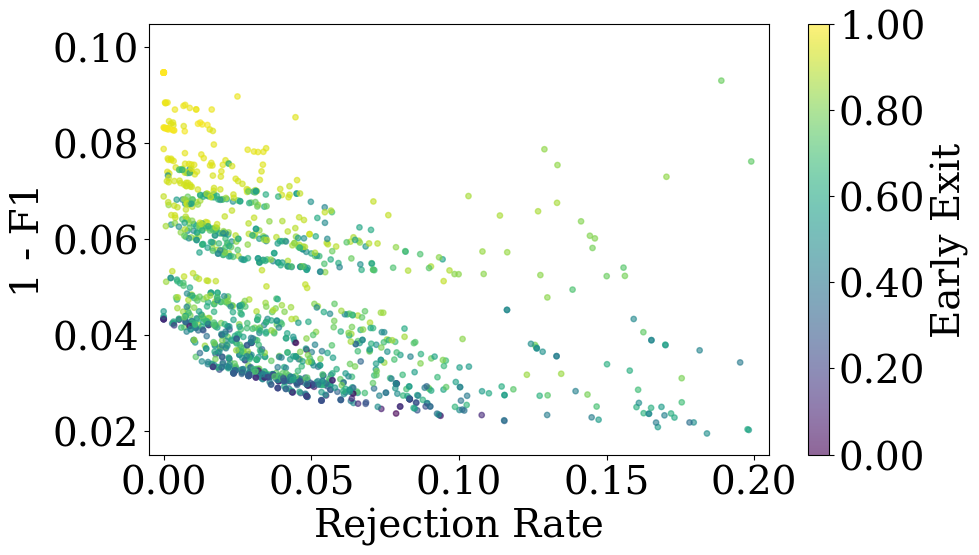

In [49]:
plot_results_from_csv('grid_search_history.csv')